# Preparation

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import yfinance
import itertools
import seaborn as sns
import pandas as pd

from models import DLS
from utils import get_data, data_preprocessing, get_tensors, evaluate_sharpe
from train import training, validate

In [2]:
start_date = '2006-02-06'
end_date = '2020-01-01'
etfs = ['VTI', 'AGG', 'DBC', '^VIX']

data = pd.DataFrame()
for etf in etfs:
    data[etf] = yfinance.Ticker(etf).history(start=start_date, end=end_date)['Close'].reset_index(drop=True)

dates = yfinance.Ticker('AGG').history(start=start_date, end=end_date).index
data.index = dates
print(data)

                                  VTI        AGG        DBC   ^VIX
Date                                                              
2006-02-06 00:00:00-05:00   44.654270  56.301731  20.889498  13.04
2006-02-07 00:00:00-05:00   44.219498  56.262348  20.285254  13.59
2006-02-08 00:00:00-05:00   44.537636  56.234276  20.198933  12.83
2006-02-09 00:00:00-05:00   44.452797  56.267975  20.388842  13.12
2006-02-10 00:00:00-05:00   44.544678  56.149986  20.017660  12.87
...                               ...        ...        ...    ...
2019-12-24 00:00:00-05:00  151.964264  99.224762  15.092732  12.67
2019-12-26 00:00:00-05:00  152.698807  99.313049  15.206423  12.65
2019-12-27 00:00:00-05:00  152.559341  99.445496  15.234848  13.43
2019-12-30 00:00:00-05:00  151.731857  99.445496  15.206423  14.82
2019-12-31 00:00:00-05:00  152.131592  99.215927  15.111680  13.78

[3500 rows x 4 columns]


<Axes: xlabel='Date'>

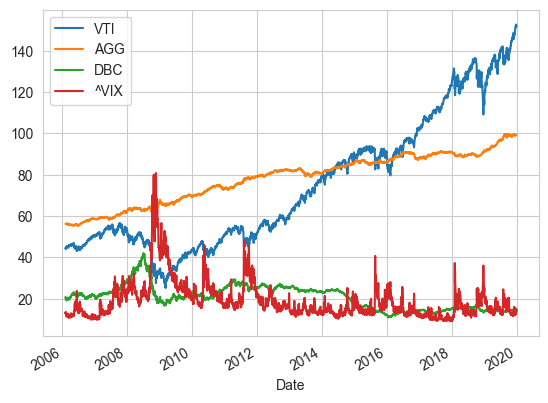

In [3]:
data.plot()

In [4]:
corr = pd.DataFrame()
for pair in list(itertools.combinations(data.pct_change().fillna(0).columns, 2)):
    corr[str(pair[0])+' & '+str(pair[1])] = data[list(pair)].rolling(50).corr().iloc[0::2,-1].droplevel(1, axis=0)

corr = corr[49:]

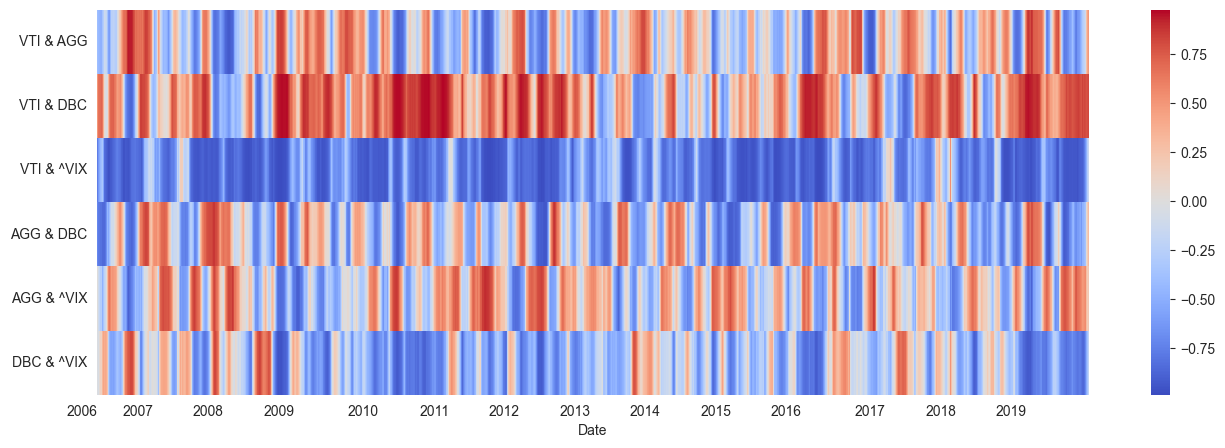

In [5]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
modified_corr = corr.copy()
modified_corr.index = corr.index.strftime('%Y')
sns.heatmap(modified_corr.transpose(), cmap='coolwarm', ax=ax)

xticks = ax.get_xticks()
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

# Filter for unique years and keep only the first occurrence
unique_labels = []
unique_xticks = []
for i, label in enumerate(xtick_labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_xticks.append(xticks[i])

# Set the xticks to show only unique years
ax.set_xticks(unique_xticks)
ax.set_xticklabels(unique_labels, rotation=0, ha='right')

plt.show()

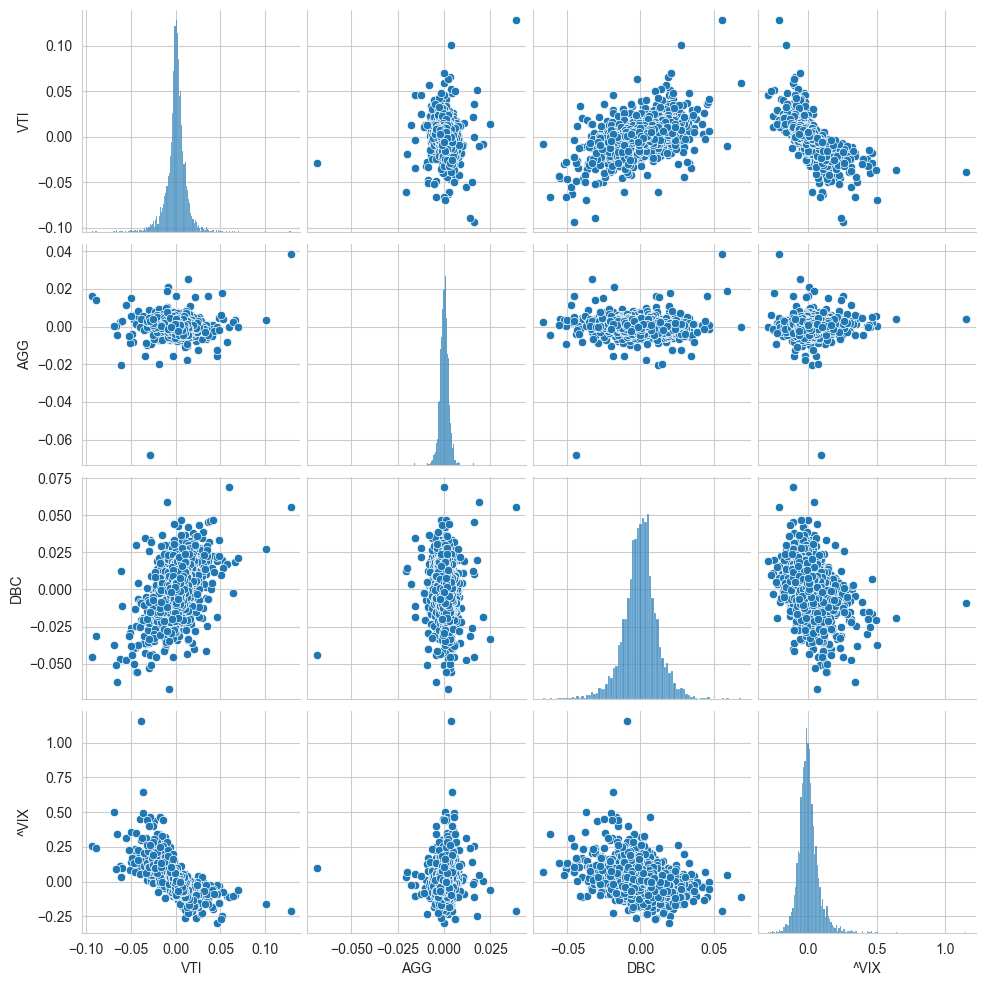

In [6]:
sns.pairplot(data.pct_change())

In [ ]:
config = {
    # Data configs
    'etfs' : ['VTI', 'AGG', 'DBC', '^VIX'],
    'start_date' : '2006-02-06',
    'end_date' : '2020-01-01',
    'train_ratio' : 0.8,
    'val_ratio' : 0.1,
    'test_ratio' : 0.1,
    'sequence_length' : 50,
    'batch_size' : 64,
    'shuffle_train' : True,
    'num_workers' : 4,
    
    # Model configs
    'volatility_scaling': 1,
    'cost_rate': 0,
    'num_layers' : 1,
    'hidden_dim' : 64,
    'dropout' : 0,
    'output_dim' : 4,
    
    # Train configs
    'epochs' : 128,
    'lr' : 0.001,
    'weight_decay' : 0.0,
    'random_seed' : 15,
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'experiment_path' : './Experiments/'
    }

In [4]:
data = get_data(etfs = config['etfs'],
                start_date = config['start_date'],
                end_date = config['end_date']
                )
train_loader, val_loader, test_loader, scaler = data_preprocessing(data, 
                                                                   train_ratio=config['train_ratio'],
                                                                   val_ratio=config['val_ratio'],
                                                                   test_ratio=config['test_ratio'],
                                                                   seq_len=config['sequence_length'],
                                                                   batch_size=config['batch_size'],
                                                                   shuffle_train=config['shuffle_train'],
                                                                   num_workers=config['num_workers']
                                                                   )

x_train, y_train = get_tensors(train_loader)
x_val, y_val = get_tensors(val_loader)
x_test, y_test = get_tensors(test_loader)

torch.Size([2750, 50, 8]) torch.Size([2750, 4])
torch.Size([300, 50, 8]) torch.Size([300, 4])
torch.Size([300, 50, 8]) torch.Size([300, 4])


# Training

## DLS LSTM

In [ ]:
model = DLS(config)

model, train_loss, val_loss, best_epoch = training(model, train_loader, val_loader, config)

test_pred = model(x_test)
test_sharpe = evaluate_sharpe(test_pred, y_test)

print('Train sharpe ratio: ', -train_loss[best_epoch])
print('Validation sharpe ratio: ', -val_loss[best_epoch])
print('Test sharpe ratio: ', test_sharpe)

## Manual Allocations (A1-A4)

## Mean-Variance Optimization (MV)

## Maximum Diversification (MD)

# Evaluation